In [1]:
pip install statsmodels


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Set random seed.
np.random.seed(42)

# Read the processed CSV file.
df = pd.read_csv("ms_data.csv")

# Convert visit_date to datetime.
df['visit_date'] = pd.to_datetime(df['visit_date'])

#  Sort by patient_id and visit_date.
df = df.sort_values(by = ['patient_id', 'visit_date'])

# Read insurance types from `insurance.lst`.
with open('insurance.lst', 'r') as f:
    insurance_types = [line.strip() for line in f.readlines()]

# Randomly assign (but keep consistent per patient_id).
unique_patients = df['patient_id'].unique()
patient_insurance_map = {patient_id: np.random.choice(insurance_types) for patient_id in unique_patients}
df['insurance_type'] = df['patient_id'].map(patient_insurance_map)

# Generate visit costs based on insurance type. Different plans have different effects on cost.
base_costs = {'Medicare': 100,
    'Medicaid': 200,
    'Private': 50,
    'Other': 500
}

# Add random variation.
variation_factor = 0.2 # 20% variation
df['visit_cost'] = df['insurance_type'].map(base_costs) * (1 + np.random.uniform(-variation_factor, variation_factor, len(df))).round(3)

# Set appropriate data types.
df['patient_id'] = df['patient_id'].astype(str)
df['education_level'] = df['education_level'].astype(str)
df['insurance_type'] = df['insurance_type'].astype(str)

# Spring: March, April, May (months 3, 4, 5)
# Summer: June, July, August (months 6, 7, 8)
# Fall: September, October, November (months 9, 10, 11)
# Winter: December, January, February (months 12, 1, 2)

# Add a 'season' column based on the month of the visit_date
def get_season(month):
    if month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    elif month in [9, 10, 11]:
        return 'Fall'
    else:
        return 'Winter'

# Apply the get_season function to the 'visit_date' to categorize the season
df['season'] = df['visit_date'].dt.month.apply(get_season)

df.head()

,patient_id,visit_date,age,education_level,walking_speed,insurance_type,visit_cost,season
0,P0001,2020-01-23,34.28,Bachelors,4.40,Private,53.95,Winter
1,P0001,2020-04-16,34.51,Bachelors,4.19,Private,50.70,Spring
2,P0001,2020-07-03,34.72,Bachelors,4.71,Private,46.20,Summer
3,P0001,2020-10-15,35.00,Bachelors,4.86,Private,56.30,Fall
4,P0001,2020-12-29,35.21,Bachelors,4.50,Private,53.70,Winter


In [5]:
# Check for duplicate rows
num_duplicates = df.duplicated().sum()
print(f"Number of duplicate rows: {num_duplicates}")

# View rows where pairs of patient_id and visit_date are repeated
duplicates = df[df.duplicated(subset=['patient_id', 'visit_date'], keep=False)]
print("Rows with repeated patient_id and visit_date pairs:")
print(duplicates)

Number of duplicate rows: 0
Rows with repeated patient_id and visit_date pairs:
Empty DataFrame
Columns: [patient_id, visit_date, age, education_level, walking_speed, insurance_type, visit_cost, season]
Index: []


In [6]:
df['visit_date'] = pd.to_datetime(df['visit_date'])
df['patient_id'] = df['patient_id'].astype(str)
df['education_level'] = df['education_level'].astype(str)
df['age'] = df['age'].astype(float)
df['walking_speed'] = df['walking_speed'].astype(float)
df['visit_cost'] = df['visit_cost'].astype(float)
df['season'] = df['season'].astype(str)
print(df.dtypes)

print(f"Number of missing values in each column: {df.isnull().sum()}")
print(f"Number of rows with at least one missing value: {df.isnull().any(axis=1).sum()}")

patient_id                 object
visit_date         datetime64[ns]
age                       float64
education_level            object
walking_speed             float64
insurance_type             object
visit_cost                float64
season                     object
dtype: object
Number of missing values in each column: patient_id         0
visit_date         0
age                0
education_level    0
walking_speed      0
insurance_type     0
visit_cost         0
season             0
dtype: int64
Number of rows with at least one missing value: 0


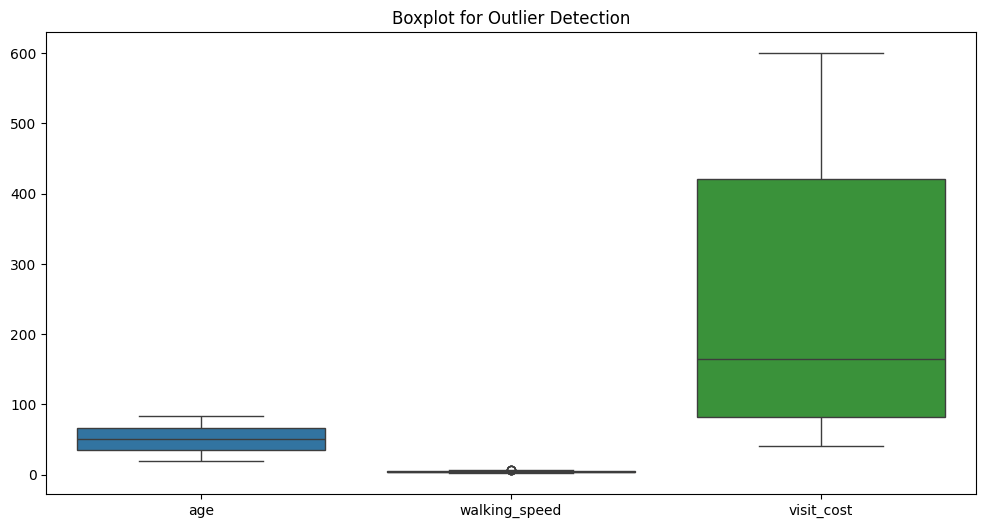

In [9]:
# Check for outliers
plt.figure(figsize=(12, 6))
sns.boxplot(data=df[['age', 'walking_speed', 'visit_cost']])
plt.title('Boxplot for Outlier Detection')
plt.show()

# remove outliers based on Z-score
z_scores = np.abs(stats.zscore(df.select_dtypes(include=[np.number])))
df = df[(z_scores < 2.5).all(axis=1)]

# Q3.1

In [10]:
# 1. Analyze walking speed:
#    - Multiple regression with education and age (report coeffcients and confidence intervals)
#    - Account for repeated measures
#    - Test for significant trends

# Prepare the data as before
X = df[['age']]
X = pd.get_dummies(df['education_level'], drop_first=True).join(X)  # Convert education_level to dummy variables
X = sm.add_constant(X)  # Add intercept

y = df['walking_speed']

# Ensure that X and y are purely numeric arrays
X = X.astype(float) 
y = y.astype(float)

# Fit the OLS model
model = sm.OLS(y, X).fit()

# Clustered standard errors by patient_id
clustered_se = model.get_robustcov_results(cov_type='cluster', groups=df['patient_id'])

# Display the summary with clustered standard errors
print(clustered_se.summary())

# Clustered Standard Errors: The cov_type='cluster' argument in get_robustcov_results accounts for the fact that there are repeated measurements for each subject. The groups=df['id'] argument specifies that the clustering should be done by the subject identifier (id).

# Interpretation: The coefficients remain the same, but now the standard errors are adjusted for the repeated measurements, which leads to more accurate statistical tests (e.g., p-values).

                            OLS Regression Results                            
Dep. Variable:          walking_speed   R-squared:                       0.806
Model:                            OLS   Adj. R-squared:                  0.806
Method:                 Least Squares   F-statistic:                 2.051e+04
Date:                Thu, 14 Nov 2024   Prob (F-statistic):               0.00
Time:                        16:58:14   Log-Likelihood:                -5297.6
No. Observations:               15385   AIC:                         1.061e+04
Df Residuals:                   15380   BIC:                         1.064e+04
Df Model:                           4                                         
Covariance Type:              cluster                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            5.5896      0.008    692.059   

In [11]:
print(clustered_se.params) # Coefficients 
print(clustered_se.pvalues) # P-values
print(clustered_se.conf_int()) # Confidence Intervals
print(clustered_se.rsquared_adj)
print(clustered_se.rsquared)

[ 5.58958787  0.4065063  -0.79216137 -0.39007949 -0.02995534]
[0.0000e+000 0.0000e+000 0.0000e+000 8.0944e-319 0.0000e+000]
[[ 5.57373854  5.60543721]
 [ 0.39295982  0.42005277]
 [-0.80536769 -0.77895505]
 [-0.40340592 -0.37675307]
 [-0.03022502 -0.02968567]]
0.8057315007682553
0.8057820125985288


In [12]:
# Test for trends.
# Manually added interaction terms between age and education_level.
# Creating new columns for each level of education.

# Convert 'education_level' into dummy variables
X_education = pd.get_dummies(df['education_level'], drop_first=True)

# Add 'age' as a predictor
X_education = X_education.join(df[['age']])

# Create interaction terms between 'age' and each education level
for level in X_education.columns[1:]:  # Skip the constant (first column)
    X_education[f'age_{level}'] = X_education['age'] * X_education[level]

# Add constant term
X_education = sm.add_constant(X_education)

# Ensure X and y are numeric
X_education = X_education.astype(float)

# Fit the OLS model
model_education = sm.OLS(y, X_education).fit()

clustered_se2 = model_education.get_robustcov_results(cov_type='cluster', groups=df['patient_id'])

# Display the model summary
print(clustered_se2.summary())

                            OLS Regression Results                            
Dep. Variable:          walking_speed   R-squared:                       0.806
Model:                            OLS   Adj. R-squared:                  0.806
Method:                 Least Squares   F-statistic:                 1.202e+04
Date:                Thu, 14 Nov 2024   Prob (F-statistic):               0.00
Time:                        17:01:25   Log-Likelihood:                -5296.2
No. Observations:               15385   AIC:                         1.061e+04
Df Residuals:                   15377   BIC:                         1.067e+04
Df Model:                           7                                         
Covariance Type:              cluster                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                5.5594      0.024  

In [13]:
X_season = pd.get_dummies(df['season'], drop_first=True)

# Add 'age' as a predictor
X_season = X_season.join(df[['age']])

# Create interaction terms between 'age' and each season
for level in X_season.columns[1:]:  # Skip the constant (first column)
    X_season[f'age_{level}'] = X_season['age'] * X_season[level]

# Add constant term
X_season = sm.add_constant(X_season)

# Ensure X and y are numeric
X_season = X_season.astype(float)

# Fit the OLS model
model_season = sm.OLS(y, X_season).fit()

clustered_se3 = model_season.get_robustcov_results(cov_type='cluster', groups=df['patient_id'])

# Display the model summary
print(clustered_se3.summary())

                            OLS Regression Results                            
Dep. Variable:          walking_speed   R-squared:                       0.509
Model:                            OLS   Adj. R-squared:                  0.509
Method:                 Least Squares   F-statistic:                     441.3
Date:                Thu, 14 Nov 2024   Prob (F-statistic):          1.74e-300
Time:                        17:01:59   Log-Likelihood:                -12436.
No. Observations:               15385   AIC:                         2.489e+04
Df Residuals:                   15377   BIC:                         2.495e+04
Df Model:                           7                                         
Covariance Type:              cluster                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.5782      0.118     47.303      0.0

# Q3.2

In [14]:
# 2. Analyze costs:
#    - Simple analysis of insurance type effect
#    - Box plots and basic statistics (report coeffcients and confidence intervals)
#    - Calculate effect sizes

# Convert insurance_type into dummy variables (one-hot encoding)
X = pd.get_dummies(df['insurance_type'], drop_first=True)

# Add 'visit_cost' as dependent variable
y = df['visit_cost']

# Add a constant to the model for intercept
X = sm.add_constant(X)

X = X.astype(float) 
y = y.astype(float)

# Fit the OLS model
model = sm.OLS(y, X).fit()

model_clustered = model.get_robustcov_results(cov_type='cluster', groups=df['patient_id'])

# Display the summary of the regression
print(model_clustered.summary())


                            OLS Regression Results                            
Dep. Variable:             visit_cost   R-squared:                       0.967
Model:                            OLS   Adj. R-squared:                  0.967
Method:                 Least Squares   F-statistic:                 1.507e+05
Date:                Thu, 14 Nov 2024   Prob (F-statistic):               0.00
Time:                        17:02:08   Log-Likelihood:                -75665.
No. Observations:               15385   AIC:                         1.513e+05
Df Residuals:                   15381   BIC:                         1.514e+05
Df Model:                           3                                         
Covariance Type:              cluster                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        199.0164      0.401    496.868      0.0

In [15]:
print(model_clustered.params) # Coefficients 
print(model_clustered.pvalues) # P-values
print(model_clustered.conf_int()) # Confidence Intervals
print(model_clustered.rsquared_adj)
print(model_clustered.rsquared)

[ 199.01642512  -99.09698836  300.00785795 -148.94851488]
[0. 0. 0. 0.]
[[ 198.23042527  199.80242497]
 [ -99.9590882   -98.23488852]
 [ 298.23074157  301.78497434]
 [-149.75725234 -148.13977742]]
0.967296907846321
0.9673032852043854


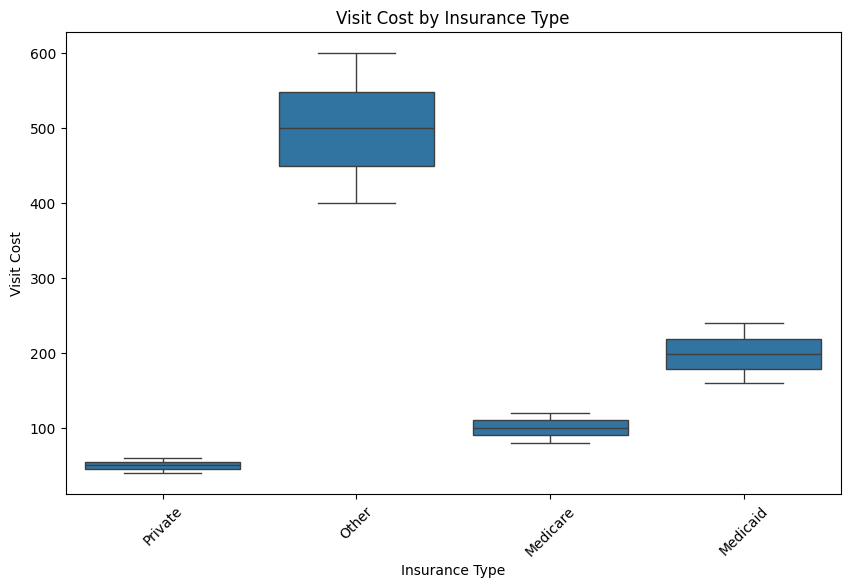

                 count        mean        std    min    25%     50%      75%  \
insurance_type                                                                 
Medicaid        3519.0  199.016425  22.999023  160.0  179.0  198.40  219.000   
Medicare        3977.0   99.919437  11.589422   80.0   90.0   99.60  110.300   
Other           4324.0  499.024283  57.575972  400.0  449.5  499.50  548.125   
Private         3565.0   50.067910   5.773130   40.0   45.0   50.05   55.100   

                  max  
insurance_type         
Medicaid        240.0  
Medicare        120.0  
Other           600.0  
Private          60.0  


In [17]:
# Box plots to visualize the distribution of visit_cost by insurance type
plt.figure(figsize=(10, 6))
sns.boxplot(x='insurance_type', y='visit_cost', data=df)
plt.title('Visit Cost by Insurance Type')
plt.xlabel('Insurance Type')
plt.ylabel('Visit Cost')
plt.xticks(rotation=45)
plt.show()

# Basic statistics for visit_cost by insurance type
statistics = df.groupby('insurance_type')['visit_cost'].describe()
print(statistics)

In [18]:
# Perform one-way ANOVA to check if visit_cost differs across insurance types
anova_result = stats.f_oneway(*(df[df['insurance_type'] == group]['visit_cost'] for group in df['insurance_type'].unique()))

# Calculate eta squared for effect size
n = len(df)
k = len(df['insurance_type'].unique())
ss_total = np.sum((df['visit_cost'] - np.mean(df['visit_cost']))**2)
ss_between = np.sum([(len(group) * (np.mean(group) - np.mean(df['visit_cost']))**2) for group in [df[df['insurance_type'] == group]['visit_cost'] for group in df['insurance_type'].unique()]])
eta_squared = ss_between / ss_total

print(f"Eta Squared: {eta_squared}")


Eta Squared: 0.9673032852043854


# Q3.3

In [19]:
# 3. Advanced analysis:
#    - Education age interaction effects on walking speed
#    - Control for relevant confounders
#    - Report key statistics and p-values (report coeffcients and confidence intervals)

# Create interaction term between age and education_level
df['age_education_interaction'] = df['age'] * df['education_level'].astype('category').cat.codes

# Fit the model using statsmodels
model = smf.ols('walking_speed ~ age + C(education_level) + age_education_interaction', data=df).fit()

# Print summary of the model
print(model.summary())

# Extract key statistics, p-values, and confidence intervals
print("\nKey Statistics:")
print("R-squared:", model.rsquared)
print("Adjusted R-squared:", model.rsquared_adj)
print("\nP-values:")
print(model.pvalues)
print("\nConfidence Intervals:")
print(model.conf_int())


                            OLS Regression Results                            
Dep. Variable:          walking_speed   R-squared:                       0.806
Model:                            OLS   Adj. R-squared:                  0.806
Method:                 Least Squares   F-statistic:                 1.276e+04
Date:                Thu, 14 Nov 2024   Prob (F-statistic):               0.00
Time:                        17:04:33   Log-Likelihood:                -5297.3
No. Observations:               15385   AIC:                         1.061e+04
Df Residuals:                   15379   BIC:                         1.065e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
Inte